#### COVID-19 Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopy
import math

import sklearn as sk

from datetime import datetime
from datetime import timedelta

In [2]:
full_data = pd.read_csv("../data/full_data_mar_18.csv")
full_data = full_data.fillna(0)
sl_data = pd.read_csv("../data/COVID-19_SL_Latest.csv", skiprows=1,
                      names=["date","new_cases","total_cases","new_deaths","total_deaths"])
sl_data.head()

,date,new_cases,total_cases,new_deaths,total_deaths
0,27-01-2020,1,1,0,0
1,28-01-2020,0,1,0,0
2,29-01-2020,0,1,0,0
3,30-01-2020,0,1,0,0
4,31-01-2020,0,1,0,0


#### Filter Data for Sri Lanka

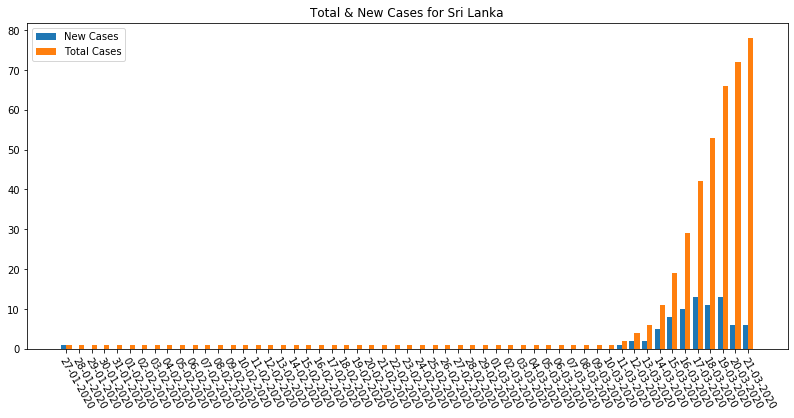

In [3]:
sl_data = sl_data[sl_data['total_cases'] > 0]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(sl_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(sl_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Sri Lanka")
ax.bar(x_ind, 'new_cases', width, data = sl_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = sl_data, label = "Total Cases")
ax.legend()
plt.show()

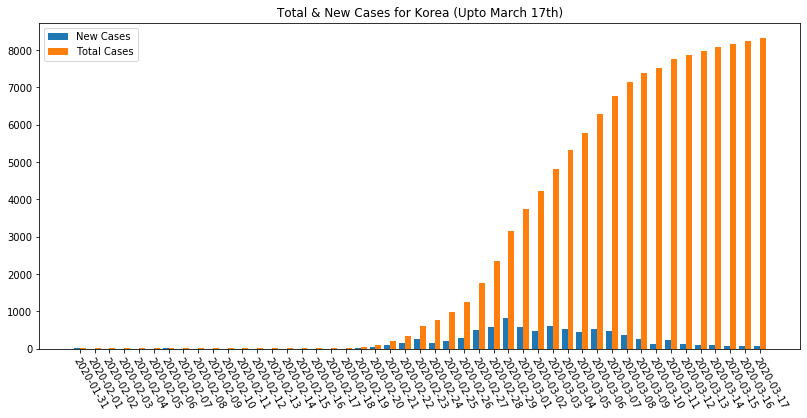

In [4]:
korea_data = full_data[(full_data['location'] == "South Korea") & (full_data['total_cases'] > 10)]
f = plt.figure(figsize=(30,6))
ax = f.add_subplot(121)
width = 0.4
x_ind = np.arange(len(korea_data['date']))
ax.set_xticks(x_ind + width / 2)
ax.set_xticklabels(korea_data['date'], rotation=-60, ha='left', rotation_mode='anchor')
ax.set_title("Total & New Cases for Korea (Upto March 17th)")

ax.bar(x_ind, 'new_cases', width, data = korea_data, label = "New Cases")
ax.bar(x_ind + width, 'total_cases', width, data = korea_data, label = "Total Cases")
ax.legend()
plt.show()

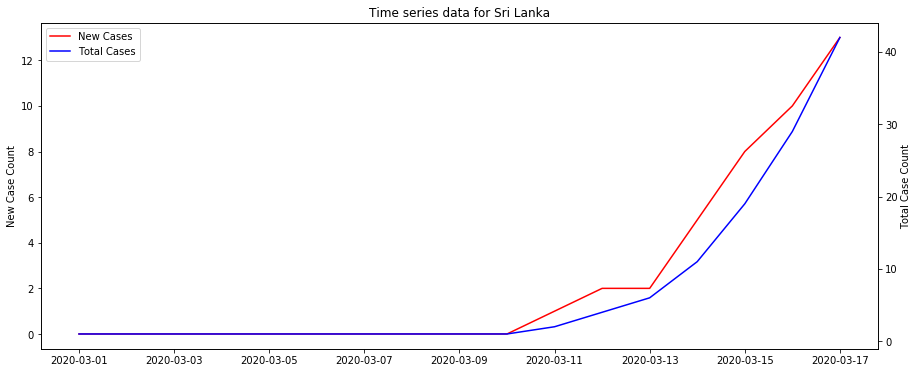

In [5]:
data_start_date = '2020-03-01'
data_end_date = '2020-03-17'
forecast_up_to = '2020-03-27'
forecast_days = pd.to_datetime(forecast_up_to) - pd.to_datetime(data_end_date)
fitted_days = pd.to_datetime(data_end_date) - pd.to_datetime(data_start_date) + timedelta(days=1)

ts_sl_data = sl_data.copy()
ts_sl_data['date'] = pd.to_datetime(ts_sl_data['date'], dayfirst=True)
ts_sl_data.set_index('date', inplace=True)
ts_sl_data = ts_sl_data.loc['2020-03-01':data_end_date].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_sl_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_sl_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for Sri Lanka")
plt.show()

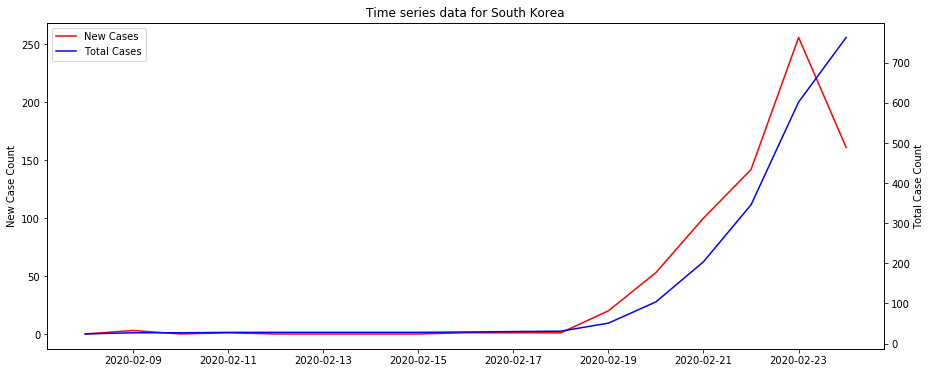

In [6]:
korea_data_end_date = pd.to_datetime('2020-02-08') + fitted_days - timedelta(days=1)
interim_korea_data = korea_data.copy()
interim_korea_data['new_cases'] = interim_korea_data['new_cases'].astype(int)
interim_korea_data['date'] = pd.to_datetime(interim_korea_data['date'])
interim_korea_data.set_index('date', inplace=True)
ts_korea_data = interim_korea_data.loc['2020-02-08':korea_data_end_date].asfreq('D')

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

ln1 = ax1.plot(ts_korea_data['new_cases'], color = 'r', label = "New Cases")
ln2 = ax2.plot(ts_korea_data['total_cases'], color = 'b', label = "Total Cases")

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

ax1.set_ylabel("New Case Count")
ax2.set_ylabel("Total Case Count")
plt.title("Time series data for South Korea")
plt.show()

In [7]:
import itertools
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

def check_ts_stationarity(ts_data, w_size):
    rolmean = ts_data.rolling(w_size).mean()
    rolstd = ts_data.rolling(w_size).std()
    plt.figure(figsize=(15,6))
    plt.plot(ts_data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation (New Cases)')
    plt.show()
    
    decomposition = sm.tsa.seasonal_decompose(ts_data, model='additive')
    fig = decomposition.plot()
    fig.set_size_inches(12,15)
    axes = fig.get_axes()
    for ax in axes:
        ax.set_xticks(ts_data.index)
        ax.set_xticklabels(ts_data.index.date, rotation=-60, rotation_mode='anchor', ha='left')
    fig.tight_layout(pad=2.0)
    plt.show()

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts_data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

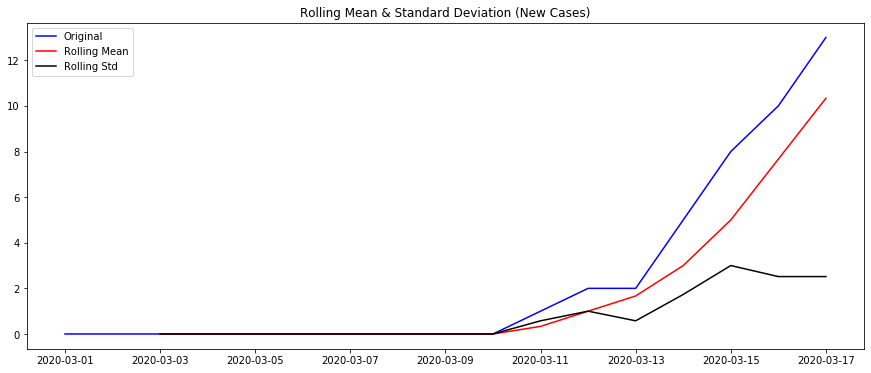

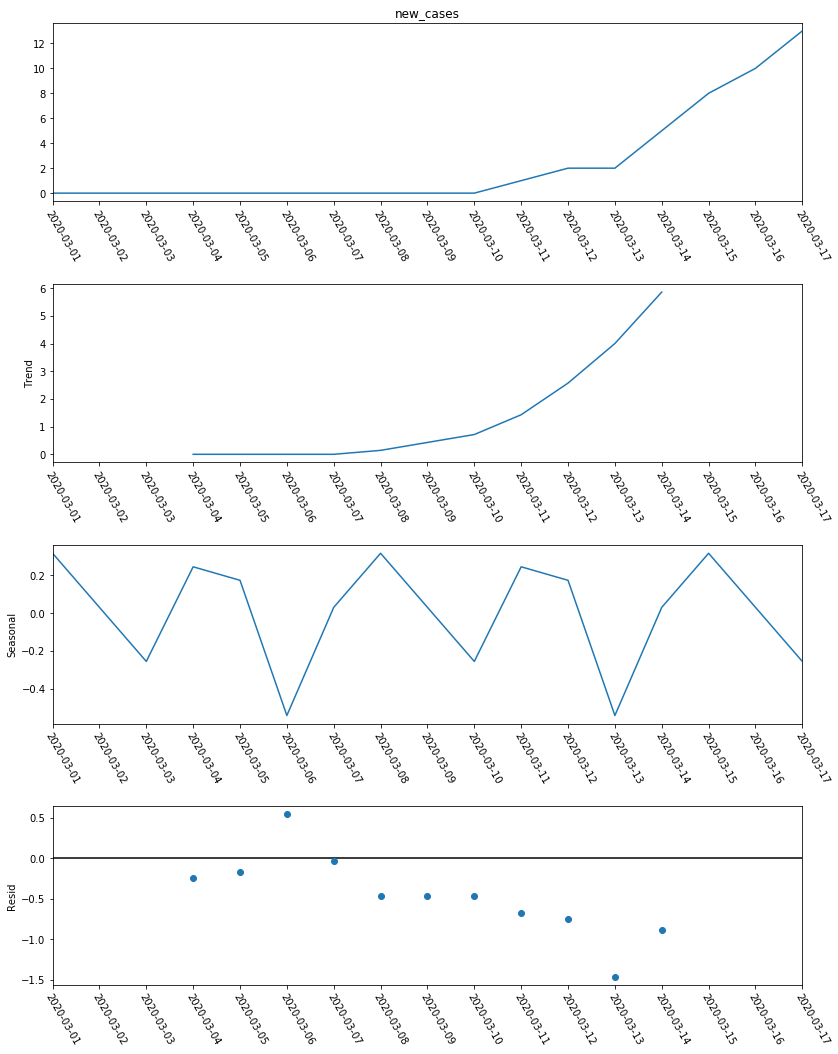

Results of Dickey-Fuller Test:
Test Statistic                 -3.334430
p-value                         0.013408
#Lags Used                      5.000000
Number of Observations Used    11.000000
Critical Value (1%)            -4.223238
Critical Value (5%)            -3.189369
Critical Value (10%)           -2.729839
dtype: float64


In [8]:
ts_sl = ts_sl_data['new_cases']
ts_korea = ts_korea_data['new_cases']
check_ts_stationarity(ts_sl, 3)

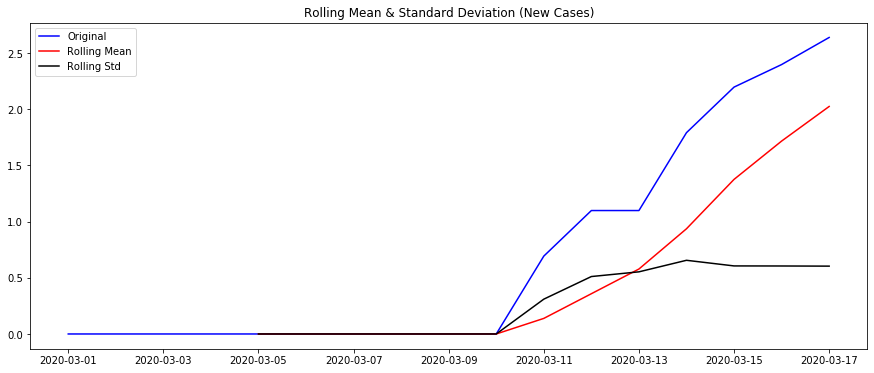

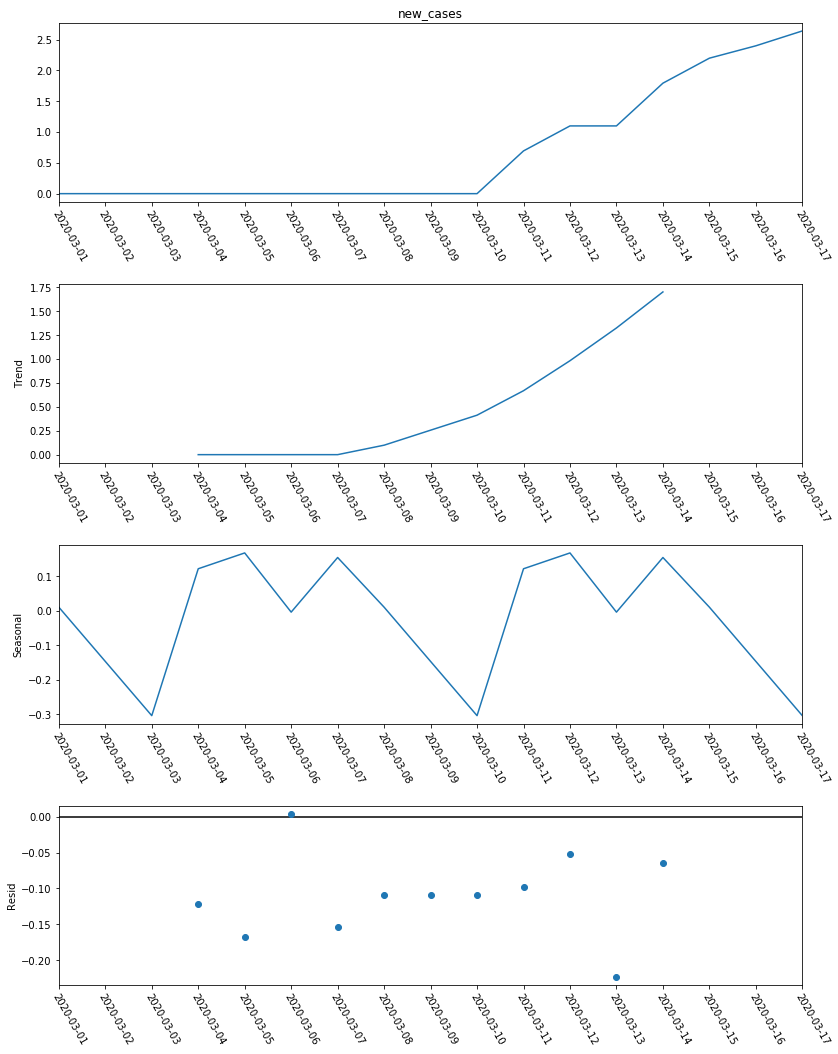

Results of Dickey-Fuller Test:
Test Statistic                  1.552953
p-value                         0.997709
#Lags Used                      0.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64


In [9]:
ts_sl_log = np.log(ts_sl + 1)
ts_korea_log = np.log(ts_korea + 1)
check_ts_stationarity(ts_sl_log, 5)

In [38]:
exog_start_date = korea_data_end_date + timedelta(days=1)
exog_end_date = korea_data_end_date + timedelta(days=(forecast_days.days))

num_index = np.arange(len(ts_sl_log))
exog_oos_korea = interim_korea_data['new_cases'].loc[exog_start_date: exog_end_date].asfreq('D')
exog_oos_korea_log = np.log(exog_oos_korea + 1)

ts_sl_numeric = ts_sl.copy()
ts_sl_numeric.index = num_index
ts_korea_numeric = ts_korea.copy()
ts_korea_numeric.index = num_index

ts_sl_log_numeric = ts_sl_log.copy()
ts_sl_log_numeric.index = num_index
ts_korea_log_numeric = ts_korea_log.copy()
ts_korea_log_numeric.index = num_index

In [73]:
prediction_ts = ts_sl_log_numeric
exog_ts = ts_korea_log_numeric
exog_oos_ts = exog_oos_korea_log

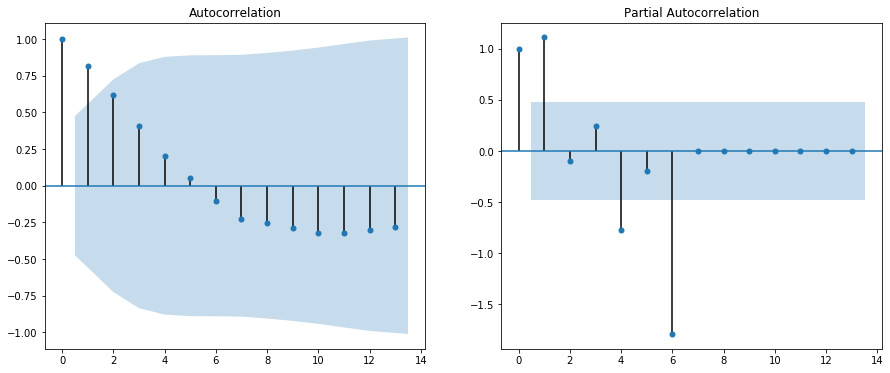

In [74]:
import statsmodels.api as sm

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
sm.graphics.tsa.plot_acf(prediction_ts, ax=ax1)
ax2 = fig.add_subplot(122)
sm.graphics.tsa.plot_pacf(prediction_ts, ax=ax2, method='ols')
plt.show()

In [75]:
from statsmodels.tsa.arima_model import ARIMA

ar_order = 1
differencing_order = 1
ma_order = 1

model = ARIMA(prediction_ts, order=(ar_order,differencing_order,ma_order))
res_ARIMA = model.fit()
res_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.new_cases   No. Observations:                   16
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  -0.067
Method:                       css-mle   S.D. of innovations              0.241
Date:                Mon, 23 Mar 2020   AIC                              8.134
Time:                        22:50:09   BIC                             11.224
Sample:                             1   HQIC                             8.292
                                                                              
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1651      0.053      3.103      0.002       0.061       0.269
ar.L1.D.new_cases     0.9630      0.106      9.107      0.000       0.756       1.170
ma.L1.D.new_cases    -1.0000      0.089    -11.243      0.000      -1.174      -0.826
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0384           +0.0000j            1.0384            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [76]:
original_date_range = pd.date_range(data_start_date,data_end_date, freq='1D').date
fitted_date_range = pd.date_range(pd.to_datetime(data_start_date) + timedelta(days=differencing_order),
                                  pd.to_datetime(data_end_date), 
                                  freq='1D').date
fcast_date_range = pd.date_range(pd.to_datetime(data_end_date) + timedelta(days=1),
                                 pd.to_datetime(data_end_date) + timedelta(days=forecast_days.days), 
                                 freq='1D').date
predicted_date_range = pd.date_range(pd.to_datetime(data_start_date) + timedelta(days=differencing_order),
                                     pd.to_datetime(data_end_date) + timedelta(days=forecast_days.days), 
                                     freq='1D').date

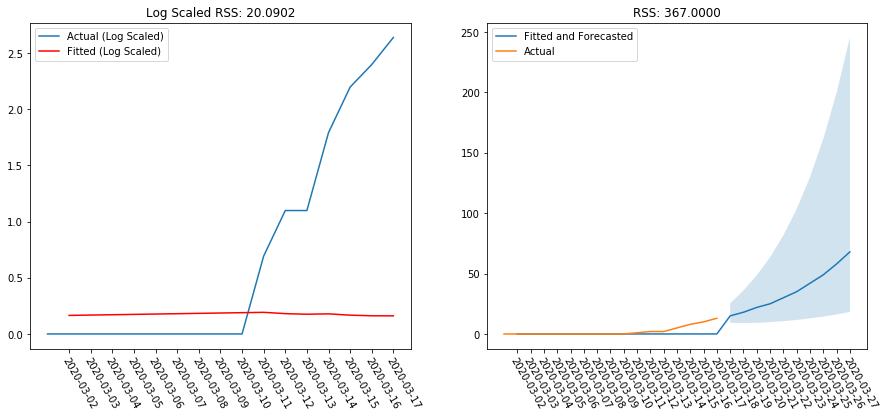

In [77]:
fitted_values = res_ARIMA.fittedvalues.copy()
fitted_values.index = fitted_date_range
fitted_scaled = np.exp(fitted_values) - 1
fitted_scaled.index = fitted_date_range
plot_prediction_ts = prediction_ts.copy()
plot_prediction_ts.index = original_date_range

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(plot_prediction_ts, label="Actual (Log Scaled)")
ax1.plot(fitted_values, color='red', label="Fitted (Log Scaled)")
ax1.set_xticks(fitted_date_range)
ax1.set_xticklabels(fitted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
ax1.set_title("Log Scaled RSS: %.4f" % sum(((fitted_values - plot_prediction_ts)**2).dropna()))
ax1.legend()

fcast = res_ARIMA.forecast(forecast_days.days)
predicted_combined = res_ARIMA.predict(differencing_order,
                                       fitted_days.days - differencing_order).append(pd.Series(fcast[0]), 
                                                                                     ignore_index=True)
predicted_scaled = round(np.exp(predicted_combined) - 1).astype(int)
predicted_scaled.index = predicted_date_range

fitted_scaled = round(np.exp(fitted_values) - 1).astype(int)
fitted_scaled.index = fitted_date_range

conf_int = fcast[2]
conf_int_lower_scaled = np.exp(conf_int[:,0]) - 1
conf_int_upper_scaled = np.exp(conf_int[:,1]) - 1

fcast_scaled = round(pd.Series(np.exp(fcast[0])) - 1).astype(int)
fcast_scaled.index = fcast_date_range

ax2 = fig.add_subplot(122)
ax2.plot(predicted_scaled, label="Fitted and Forecasted")
ax2.plot(ts_sl, label="Actual")
ax2.fill_between(fcast_date_range, conf_int_lower_scaled, conf_int_upper_scaled, alpha=0.2)
ax2.legend(loc=2)
ax2.set_xticks(predicted_date_range)
ax2.set_xticklabels(predicted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
plt.title("RSS: %.4f" % sum(((fitted_scaled - ts_sl)**2).dropna()))

plt.show()

In [78]:
print(fcast_scaled)

2020-03-18    15
2020-03-19    18
2020-03-20    22
2020-03-21    25
2020-03-22    30
2020-03-23    35
2020-03-24    42
2020-03-25    49
2020-03-26    58
2020-03-27    68
dtype: int64


In [79]:
from statsmodels.tsa.arima_model import ARIMA

ar_order = 1
differencing_order = 0
ma_order = 3

model_exog = ARIMA(prediction_ts, order=(ar_order,differencing_order,ma_order), exog=exog_ts)
res_ARIMA_exog = model_exog.fit(trend='nc', disp=-1)
res_ARIMA_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              new_cases   No. Observations:                   17
Model:                     ARMA(1, 3)   Log Likelihood                  -2.692
Method:                       css-mle   S.D. of innovations              0.283
Date:                Mon, 23 Mar 2020   AIC                             17.384
Time:                        22:50:19   BIC                             22.383
Sample:                             0   HQIC                            17.881
                                                                              
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
new_cases           0.4098      0.025     16.590      0.000       0.361       0.458
ar.L1.new_cases     0.2735     11.078      0.025      0.980     -21.439      21.986
ma.L1.new_cases    -0.1617     11.072     -0.015      0.988     -21.863      21.539
ma.L2.new_cases    -0.1931      1.258     -0.154      0.878      -2.658       2.272
ma.L3.new_cases     0.0413      1.812      0.023      0.982      -3.511       3.594
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.6567           +0.0000j            3.6567            0.0000
MA.1           -2.1849           +0.0000j            2.1849            0.5000
MA.2            2.6021           +0.0000j            2.6021            0.0000
MA.3            4.2539           +0.0000j            4.2539            0.0000
-----------------------------------------------------------------------------
"""

In [80]:
original_date_range = pd.date_range(data_start_date,data_end_date, freq='1D').date
fitted_date_range = pd.date_range(pd.to_datetime(data_start_date) + timedelta(days=differencing_order),
                                  pd.to_datetime(data_end_date), 
                                  freq='1D').date
fcast_date_range = pd.date_range(pd.to_datetime(data_end_date) + timedelta(days=1),
                                 pd.to_datetime(data_end_date) + timedelta(days=forecast_days.days), 
                                 freq='1D').date
predicted_date_range = pd.date_range(pd.to_datetime(data_start_date) + timedelta(days=differencing_order),
                                     pd.to_datetime(data_end_date) + timedelta(days=forecast_days.days), 
                                     freq='1D').date

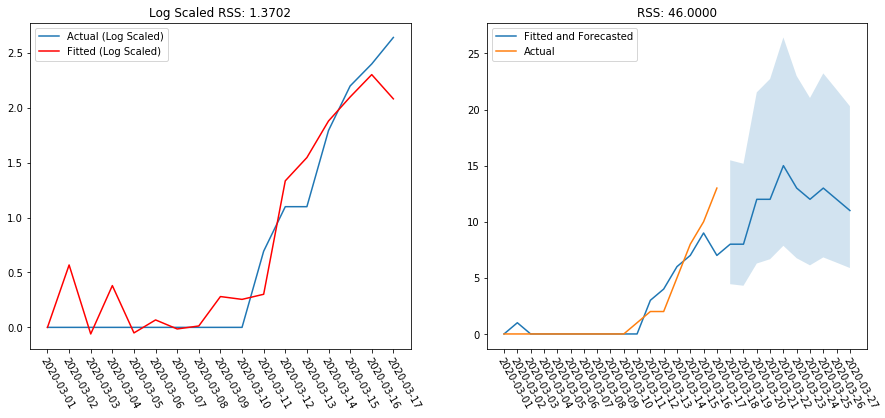

In [81]:
fitted_values = res_ARIMA_exog.fittedvalues.copy()
fitted_values.index = fitted_date_range
fitted_scaled = np.exp(fitted_values) - 1
fitted_scaled.index = fitted_date_range
plot_prediction_ts = prediction_ts.copy()
plot_prediction_ts.index = fitted_date_range

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(plot_prediction_ts, label="Actual (Log Scaled)")
ax1.plot(fitted_values, color='red', label="Fitted (Log Scaled)")
ax1.set_xticks(fitted_date_range)
ax1.set_xticklabels(fitted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
ax1.set_title("Log Scaled RSS: %.4f" % sum(((fitted_values - plot_prediction_ts)**2).dropna()))
ax1.legend()

predicted_scaled = round(np.exp(res_ARIMA_exog.predict(0,len(predicted_date_range)-1, exog=exog_oos_ts)) - 1).astype(int)
predicted_scaled.index = predicted_date_range

fitted_scaled = round(np.exp(fitted_values) - 1).astype(int)
fitted_scaled.index = fitted_date_range

fcast = res_ARIMA_exog.forecast(forecast_days.days, exog=exog_oos_korea_log)
conf_int = fcast[2]
conf_int_lower_scaled = np.exp(conf_int[:,0]) - 1
conf_int_upper_scaled = np.exp(conf_int[:,1]) - 1

fcast_scaled = round(pd.Series(np.exp(fcast[0])) - 1).astype(int)
fcast_scaled.index = fcast_date_range

ax2 = fig.add_subplot(122)
ax2.plot(predicted_scaled, label="Fitted and Forecasted")
ax2.plot(ts_sl, label="Actual")
ax2.fill_between(fcast_date_range, conf_int_lower_scaled, conf_int_upper_scaled, alpha=0.2)
ax2.legend(loc=2)
ax2.set_xticks(predicted_date_range)
ax2.set_xticklabels(predicted_date_range, rotation=-60, rotation_mode='anchor', ha='left')
plt.title("RSS: %.4f" % sum(((fitted_scaled - ts_sl)**2).dropna()))

plt.show()

In [82]:
print(fcast_scaled)

2020-03-18     8
2020-03-19     8
2020-03-20    12
2020-03-21    12
2020-03-22    15
2020-03-23    13
2020-03-24    12
2020-03-25    13
2020-03-26    12
2020-03-27    11
dtype: int64
